In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import libraries**

These libraries have all the tools to realise the Machine Leraning task.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline
from sklearn import tree
from sklearn import linear_model
from sklearn import ensemble
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from scipy import stats

**Function definition**

This functions realise the clean step on coluns. it prepare dataset to be used:

In [ ]:
# defining a clean function

def clean_price(df, columns):
  '''
  return a df with removed symbols and converted values from string to numerical values

  Input:
    df: pandas dataframe
    columns: list of columns to clean

  Output:
    df: pandas dataframe
  '''

  for i in columns:
    df[f'{i}_num'] = df[i].str.replace('$', '').str.replace(',', '').astype(float)

  return df

In [ ]:
# define a clean simbols and decimal transformation
def decimal_rate(df, columns):
  '''
  retur a df with cleaned simbols and decimal transformation

  Input:
    df: pandas dataframe
    columns: list of columns to clean

  Output:
    df: pandas dataframe
  '''

  for i in columns:
    df[f'{i}_num'] = df[i].str.replace('%', '').astype(float)/100

  return df

In [ ]:
# mapping t/f to binary 1/0
def map_to_bin(df, columns):
  '''
  retur a df with mapped values to binary 1-True 0-False

  Input:
    df: pandas dataframe
    columns: list of columns to clean

  Output:
    df: pandas dataframe
  '''

  for i in columns:
    df[f'{i}_bin'] = df[i].map({'t': 1, 'f': 0})

  return df

This function realise the task of train some models and return a dataframe with metrics for each the model:

In [ ]:
# funtion to fit models
def train_model(df, model_list, target='price_num'):
  '''
  This function train some models and return a data set with metrics for each the model.

    input:
        df: DataFrame, the data includin the target variable and features.
        model_list: list, the list of models to train.
        target: string, the target variable name.

    output:
        metrics_result: DataFrame, the metrics result table for each model.
  '''

  #drop the columns remaining with NaN values
  df = df.dropna(axis=0)

  # defining the X matrix with variables and y series target
  X = df.drop(target, axis=1)
  y = df[target]

  # define the preprocessor columns
  categorical_features = X.select_dtypes(include=['object']).columns.tolist()
  numerical_features = X.select_dtypes(include=['number']).columns.tolist()

  # instantiate the preprocessor
  preprocessor = ColumnTransformer(transformers=[
        ('cat', preprocessing.OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), categorical_features),
        ('num', preprocessing.StandardScaler() , numerical_features)])

  # split the data into train/test sets
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

  # define the metrics variables lists
  r2_train = []
  r2_test = []
  RMSE_train = []
  RMSE_test = []
  modelslist = []

  # loop through the models with a pipeline, run predict method and calculate the metrics variables
  for model in model_list:

    my_pipeline = pipeline.Pipeline([
      ('preprocessor', preprocessor),
      ('model', model),
      ])

    my_pipeline.fit(X_train, y_train)

    y_train_predict = my_pipeline.predict(X_train)
    y_test_predict = my_pipeline.predict(X_test)

    r2_train.append(metrics.r2_score(y_train, y_train_predict))
    r2_test.append(metrics.r2_score(y_test, y_test_predict))

    RMSE_train.append(np.sqrt(((y_train - y_train_predict) ** 2).mean()))
    RMSE_test.append(np.sqrt(((y_test - y_test_predict) ** 2).mean()))


    # print statements
    print(f'{model.__class__.__name__} was finished')

    # append the name of each model used
    modelslist.append(model.__class__.__name__)

  # create the metrics dataset
  metrics_result = pd.DataFrame([[round(num, 2) for num in r2_train],[round(num, 2) for num in r2_test],
                                [round(num, 2) for num in RMSE_train], [round(num, 2) for num in RMSE_test] ],
                                index = ['R2_train', 'R2_test', 'RMSE_train', 'RMSE_test'], columns = modelslist)

  print('***********************\n\n')

  return metrics_result

***Business Understanding***
<h1><b> **Boston Airbnb Open Data: A Data Science Approach**</b></h1>

<h2>Machine Learning:</h2>

<h3>The objective is to apply machine leraning models to data in order to predict the rent tax payable on a property.</h3>

<h2><br>Key goals include:</br></h2>

* Data understand
* Data clean, fill NaN and filter
* Select variables
* fit models
* visualize and evaluate model metrics  

***Data Understanding***

<h3>Gather the data:</h3



**Airbnb data set:**
A sneak peek into the Airbnb activity in Boston, MA, USA from Kaggle.com. https://www.kaggle.com/datasets/airbnb/boston


In [ ]:
df_listings = pd.read_csv('/content/drive/MyDrive/UDACITY/Project: Writing a Data Scientist Blog Post/listings.csv')

<h3>The Data info list</h3>

In [ ]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [ ]:
# see the percentage of the null values inside each feature
(df_listings.isnull().sum()[df_listings.isnull().sum() > 0]/len(df_listings)).sort_values(ascending=False)

jurisdiction_names              1.000000
license                         1.000000
neighbourhood_group_cleansed    1.000000
has_availability                1.000000
square_feet                     0.984379
monthly_price                   0.752301
weekly_price                    0.751185
security_deposit                0.625662
notes                           0.550907
interaction                     0.433473
access                          0.415342
neighborhood_overview           0.394700
host_about                      0.365132
transit                         0.359833
house_rules                     0.332497
cleaning_fee                    0.308787
space                           0.294840
review_scores_accuracy          0.229568
review_scores_location          0.229289
review_scores_value             0.229010
review_scores_checkin           0.228731
review_scores_communication     0.228173
review_scores_cleanliness       0.228173
review_scores_rating            0.226778
first_review    

There are four feature where no data at all and other with high proportion of missing values. This is a significant issue.

<h3>Data Preparation</h3>

**Strategy:**

* Drop variables that don't have relevant information for the model

* Adjusting values to float, eliminating symbols, converting to decimal rate, mapping t/f to binary 1/0.

* Apply the defined fill NaN values rules



In [ ]:
# Drop variables that don't have relevant information for the model
df_drop = df_listings.drop(['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_location',
 'host_about',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'street',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'smart_location',
 'country_code',
 'amenities',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'calendar_updated',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'calendar_last_scraped',
 'number_of_reviews',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'requires_license',
 'license',
 'jurisdiction_names',
 'calculated_host_listings_count',
 'reviews_per_month',
  'host_has_profile_pic',
  'market',
  'country',
  'square_feet'],
                 axis = 1)

In [ ]:
#Adjusting values to float and eliminating symbols.
df_drop = clean_price(df_drop, ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee'])

In [ ]:
#converting to decimal rate and eliminating simbols
df_drop = decimal_rate(df_drop, ['host_response_rate', 'host_acceptance_rate'])

In [ ]:
# mapping t/f to binary 1/0
df_drop = map_to_bin(df_drop, ['host_is_superhost', 'instant_bookable', 'host_identity_verified',
                               'is_location_exact', 'require_guest_profile_picture', 'require_guest_phone_verification'])

In [ ]:
# make a deep copy of the data
df = df_drop.copy(deep=True)

with the transformation above the Data was prepared to the next step: The NaN solutions.

<h3>The NaN values strategy</h3>

To avoid eliminating data and losing information by simply dropping the lines with missing values, the missing values were filled in.

Here it was done by ***manually*** checking the groupby table of the feature against price_num and applying the rules:

 1. generated the groupby table

 2. find the NaN's price mode value

 3. find the other price mode that is equal (or close to) NaN's price mode and select the value associated

 4. fill the NaN with the value associated

*It has not been automated here, but it is possible.*

In [ ]:
#listing the columns with NaN values to be analised
df.columns[df.isnull().sum() > 0].tolist()

['host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'neighbourhood',
 'property_type',
 'bathrooms',
 'bedrooms',
 'beds',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'weekly_price_num',
 'monthly_price_num',
 'security_deposit_num',
 'cleaning_fee_num',
 'host_response_rate_num',
 'host_acceptance_rate_num']

In [ ]:
# this is the groupby code
df.groupby('host_response_time', dropna=False)['price_num'].agg([pd.Series.mode, 'mean', 'count']).sort_values('mean').head(50)

,mode,mean,count
host_response_time,,,
a few days or more,100.0,150.627907,43
within a day,"[100.0, 150.0]",155.127932,469
within an hour,200.0,160.638728,1384
within a few hours,150.0,190.050082,1218
NaN,200.0,192.116773,471


This figure below ilustrate the process for the **host_response_time** categories and the **price_num** associated:


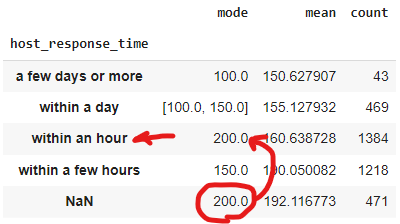

Similarly, changing the name of the feature column in the grouby code will enable the process to be applied to the others features.

<h4>The next step is insert the values in accordance with the process outlined above:</h4>

In [ ]:
# STRATEGY for NaN values:
# obserb the groupby table above: generated by df.groupby('***feature with NaN***', dropna=False)['price_num'].agg([pd.Series.mode, 'mean', 'count']).sort_values('mean').head(50)
# find the NaN price mode
# find the other price mode that is equal (or close to) NaN price mode and select the value associated
# fill the NaN with the value associated

df['host_response_time'] = df['host_response_time'].fillna('within an hour')
df['host_response_rate'] = df['host_response_rate'].fillna('97%')
df['host_acceptance_rate'] = df['host_acceptance_rate'].fillna('81%')
df['neighbourhood'] = df['neighbourhood'].fillna('South Boston')
df['property_type'] = df['property_type'].fillna('other')
df['bathrooms'] = df['bathrooms'].fillna(0.0)
df['bedrooms'] = df['bedrooms'].fillna(2)
df['beds'] = df['beds'].fillna(1)
df['security_deposit'] = df['security_deposit'].fillna('$100.00')
df['cleaning_fee'] = df['cleaning_fee'].fillna('$0')
df['security_deposit_num'] = df['security_deposit_num'].fillna(100)
df['cleaning_fee_num'] = df['cleaning_fee_num'].fillna(0)
df['host_response_rate_num'] = df['host_response_rate_num'].fillna(0.97)
df['host_acceptance_rate_num'] = df['host_acceptance_rate_num'].fillna(0.81)

#df['weekly_price'] = df['weekly_price'].fillna() discarted!!!
#df['monthly_price'] = df['monthly_price'].fillna() discarted!!!!
#df['weekly_price_num'] = df['weekly_price_num'].fillna() discarted!!!!
#df['monthly_price_num'] = df['monthly_price_num'].fillna() discarted!!!!


Check the remaining NaN values:

In [ ]:
# Check the remaining NaN values
(df.isnull().sum()[df.isnull().sum() > 0]/len(df)).sort_values(ascending=False)

monthly_price        0.752301
monthly_price_num    0.752301
weekly_price         0.751185
weekly_price_num     0.751185
dtype: float64

only the discarded features remain with NaN. The fill NaN values was finished here.

<h3>Modeling</h3>

<h3><b>Feature selection to the train model task</b></h3>

The goal for this section is: What are the most important variables to estimate the price?

***Strategy:*** think about what property's features affec its rental price.

**Feature Selected:** latitude, longitude, accommodates, bathrooms, bedrooms, beds, is_location_exact, cleaning_fee, property_type and neighbourhood. These features seem to be related to the price.

First of all, the data was filtered by price < 750, eliminating some price oulier values from the dataset. This prevent strong distortion to regression models.

In [ ]:
df_lim = df[df['price_num'] < 750]

Next, list the features that are relevant and set them to the 'X' matrix of features.

In [ ]:
X=df_lim[[
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'is_location_exact_bin',
 'cleaning_fee_num',
 'property_type',
 'neighbourhood',
 ]]

set the target variable:

In [ ]:
y=df_lim['price_num']

cheking internal feature correlations:

<Axes: >

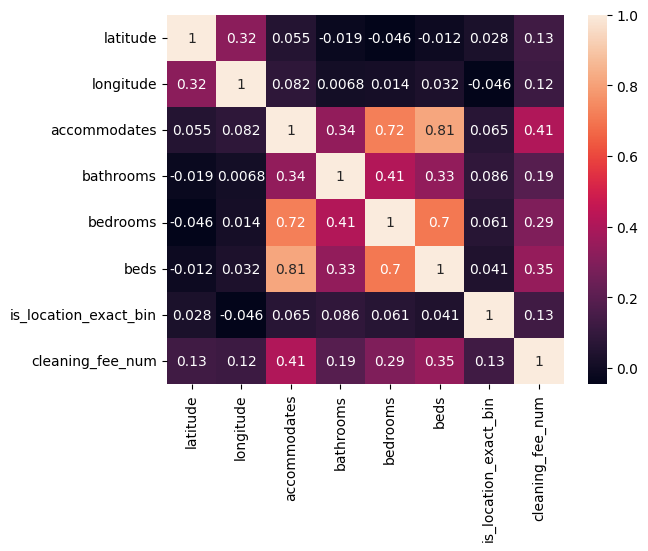

In [ ]:
sns.heatmap(X.select_dtypes('number').corr(), annot=True)

there are no strong internal correlation: it is important to statistic regression.

Plotting the features x price_num correlation:

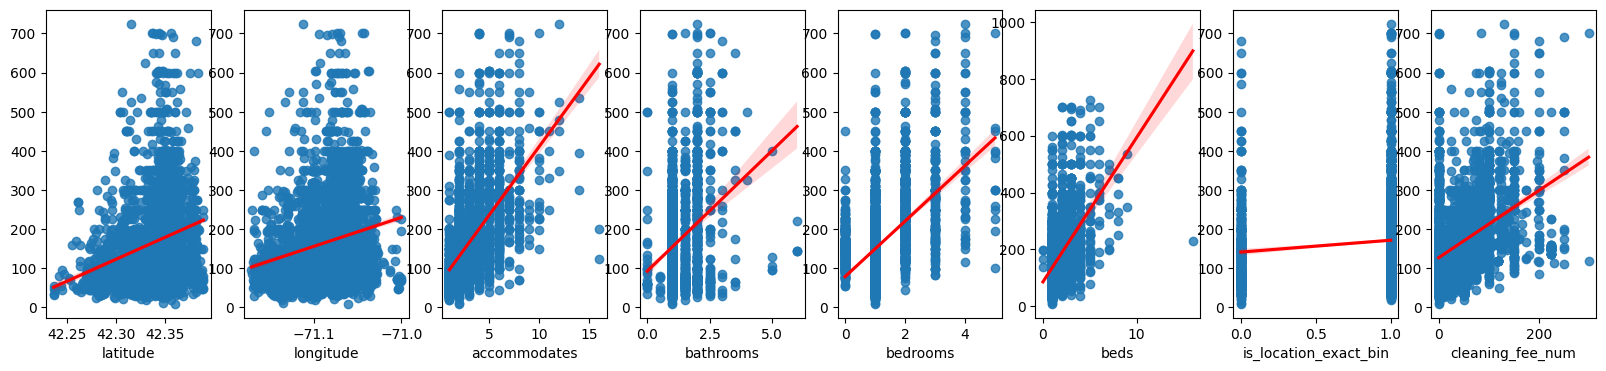

In [ ]:
# plot the feture x price_num correlation

fig, ax = plt.subplots(1,len(X.select_dtypes('number').columns), figsize=(20, 4))

for i, j in enumerate(X.select_dtypes('number').columns):
  sns.regplot(x=df_lim[j], y=y, scatter=True, fit_reg=True, line_kws=dict(color="r"), ax=ax[i])
  ax[i].set_ylabel('')
plt.show()

While the common plot of correlations may not be immediately apparent, they are nevertheless present to some extent.

<h3>Data Modeling</h3>

**OLS steps strategy:**

  1. listing categorical_features and numerical_features

  2. instatiate a preprocessor for the numeric values

  3. create a formula to pass to the OLS model

  4. create specific df_ols dataframe to pass to the OLS model

  5. fit the model

  6. display the summary statistics

  7. interpret the summary

In [ ]:
# listing categorical_features and numerical_features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()

In [ ]:
# instatiate a preprocessor for the numeric values
preprocessor = ColumnTransformer(transformers=[
      ('num', preprocessing.StandardScaler() , numerical_features)])

# create a processed data frame
df_processor = pd.DataFrame(preprocessor.fit_transform(df), columns=[i.replace(' ','_').replace('-', '_').replace('/', '_').replace('&', '_') for i in preprocessor.get_feature_names_out().tolist()])

In [ ]:
# create a formula to pass to the OLS model
f =[]
for i in df_processor.columns.tolist():
  f.append(f'{i} + ')

f_cont = ''.join(f)
f_cont = f_cont[:-3]

In [ ]:
#create specific df_OLS dataframe to pass to the OLS model
df_ols = pd.concat([df_processor, y], axis=1)

In [ ]:
# fit the OLS model and display the summary statistics
ols_formula = f'price_num ~ {f_cont}'

OLS = ols(formula = ols_formula, data = df_ols)
model = OLS.fit()

In [ ]:
# display the summary
model_results = model.summary()
display(model_results)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_num   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     364.7
Date:                Thu, 13 Jun 2024   Prob (F-statistic):               0.00
Time:                        12:16:33   Log-Likelihood:                -20649.
No. Observations:                3565   AIC:                         4.132e+04
Df Residuals:                    3556   BIC:                         4.137e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    167.9406      1.330    126.280      0.000     165.333     170.548
num__latitude                 19.8065      1.419     13.956      0.000      17.024      22.589
num__longitude                11.4846      1.412      8.132      0.000       8.716      14.254
num__accommodates             37.5652      2.541     14.781      0.000      32.582      42.548
num__bathrooms                 7.2998      1.489      4.901      0.000       4.380      10.220
num__bedrooms                 20.2935      2.090      9.708      0.000      16.195      24.392
num__beds                     -3.1282      2.418     -1.294      0.196      -7.868       1.612
num__is_location_exact_bin     3.8082      1.350      2.822      0.005       1.162       6.454
num__cleaning_fee_num         19.4228      1.489     13.040      0.000      16.502      22.343
==============================================================================
Omnibus:                     1025.254   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4557.810
Skew:                           1.328   Prob(JB):                         0.00
Kurtosis:                       7.861   Cond. No.                         4.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Summary**

* This summary shows the most relevant satatistics to the OLS fitted model.

* The R-squared 0.451 value in the OLS summary is NOT good enoff to validate the model, even the p-values shows good results for the representativity of the coeficients.

* However, strictly speaking, in these regression coefficients, latitude, longitude, accommodation and bedrooms have the most influence on the price.

**checking the qualit of the model**




Text(0.5, 1.0, 'Normal Q-Q plot')

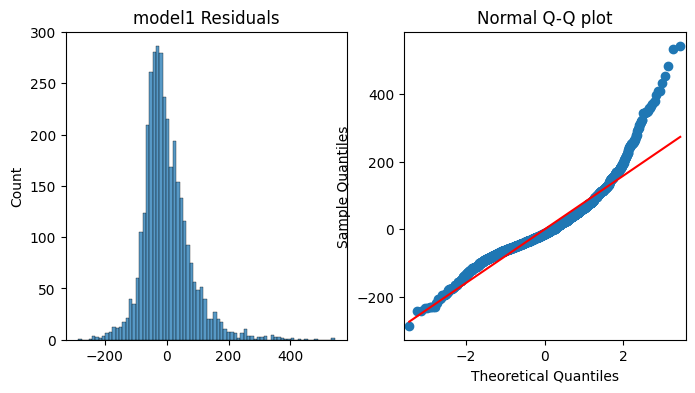

In [ ]:
# plot statistic merics and visualization
residual = model.resid

fig, axes = plt.subplots(1, 2, figsize = (8,4))

sns.histplot(residual, ax=axes[0])
axes[0].set_title("model1 Residuals")

sm.qqplot(residual, line='s',ax = axes[1])
axes[1].set_title("Normal Q-Q plot")

The histogram of the residuals is noticeably skewed, and the QQ plot indicates potential issues at the upper end. It is evident that the normality assumption has been violated.

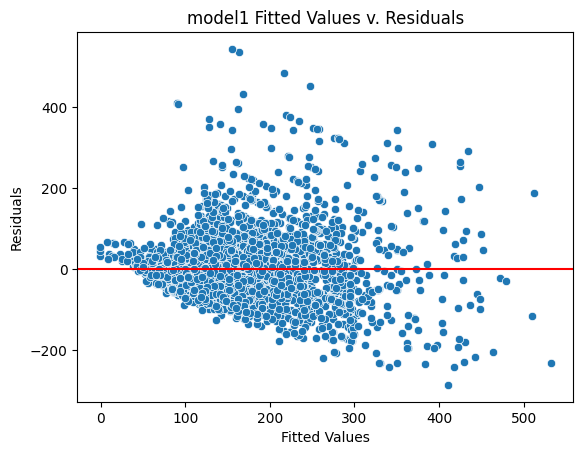

In [ ]:
# plot the residuals
fig = sns.scatterplot(x = model.fittedvalues, y = model.resid)
fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")
fig.set_title("model1 Fitted Values v. Residuals")
fig.axhline(0, color='red')
plt.show()

The fitted values and residuals indicate a lack of balance with the up from zero line, and an increase in dispersion from left to right. This suggests that the observation independence (homoscedasticity) has been compromised.

... mybe decide to discad this model!

**Scikitlearn library Strategy:**

1. instantiate and list the models to fit

2. apply the train_model() function defined

In [ ]:
# instantiate the models
model1 = linear_model.LinearRegression()
model3 = linear_model.LassoCV()
model4 = linear_model.ElasticNet()
model2 = linear_model.RidgeCV()
model5 = ensemble.RandomForestRegressor()
model6 = tree.DecisionTreeRegressor()

# put the models in a list
model_list = [model1, model2, model3, model4, model5, model6]

In [ ]:
#train with full df
train_model(df, model_list, 'price_num')

LinearRegression was finished
RidgeCV was finished
LassoCV was finished
ElasticNet was finished
RandomForestRegressor was finished
DecisionTreeRegressor was finished
***********************




,LinearRegression,RidgeCV,LassoCV,ElasticNet,RandomForestRegressor,DecisionTreeRegressor
R2_train,1.00,0.94,0.89,0.81,0.97,1.00
R2_test,0.87,0.88,0.88,0.81,0.83,0.73
RMSE_train,0.00,26.54,35.17,45.77,19.38,0.00
RMSE_test,43.50,42.72,42.84,52.53,50.67,63.46


Using the full df, the ElasticNet and the RandomForestRegressor was primissor. Especially the RandomForestRegressor gives good metrics. However, we can refine the training step for the RandomForestRegressor by applying the GridSearchCV and tuning the hyperparameters of the model.

In [ ]:
#train with df limite by < 750 price
train_model(df_lim, model_list, 'price_num')

LinearRegression was finished
RidgeCV was finished
LassoCV was finished
ElasticNet was finished
RandomForestRegressor was finished
DecisionTreeRegressor was finished
***********************




,LinearRegression,RidgeCV,LassoCV,ElasticNet,RandomForestRegressor,DecisionTreeRegressor
R2_train,1.00,0.94,0.90,0.83,0.98,1.00
R2_test,0.84,0.86,0.84,0.83,0.83,0.64
RMSE_train,0.00,24.48,31.40,41.40,15.77,0.00
RMSE_test,40.42,38.05,39.81,41.69,41.19,60.72


The use of df_lim, where only the samples with price_num < 750 were used, shows an improvement in the metric results of the linear regressors due to the removed outliers. It is important to note that the RandomForestRegressor was not changed in any significant way.

In [ ]:
#train with df_ols used in the OLS regression
train_model(df_ols, model_list, 'price_num')

LinearRegression was finished
RidgeCV was finished
LassoCV was finished
ElasticNet was finished
RandomForestRegressor was finished
DecisionTreeRegressor was finished
***********************




,LinearRegression,RidgeCV,LassoCV,ElasticNet,RandomForestRegressor,DecisionTreeRegressor
R2_train,0.46,0.46,0.46,0.44,0.95,1.00
R2_test,0.43,0.43,0.43,0.41,0.61,0.33
RMSE_train,77.64,77.64,77.68,79.16,24.12,0.00
RMSE_test,83.10,83.10,83.16,84.64,68.52,90.25


Finally, using the df_ols, which have fewer features and price_num < 750, the linear regressors metrics show practically the same result as in the OLS model. Note that the RandomForestRegressor doesn't show any significant changes because it is not sensitive to normality deviations as the linear regressors are.

<h1>Conclusion:</h1>

* A data source was prepared and a number of models were fitted to the data. Here the data preparation was done on the whole dataset, but it is not practice to apply the steps used here to a real word. However, this notebook shows how the train/test split works and the power of some of the regressors.

* The features selected for df_ols and fitted by the OLS model were not sufficient to give good predictions. According to the RMSE of df_ols fitted by LinearRegression, the same was found and the predicted price will show an error around $83, which is not so good.

* To go aread, the GridserachCV can be used to tunning the RandomForestRegressor and get bether results.

For now we will stop here.




